In [56]:
#### RESEEDED

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer

In [16]:
with open('features.pkl', 'rb') as f:
    df_features = pickle.load(f)
with open('objetivos.pkl', 'rb') as f:
    df_objetivos = pickle.load(f)
with open('dates.pkl', 'rb') as f:
    dates = pickle.load(f)

X = np.array(df_features)
y = np.array(df_objetivos[['House.overall..kW.']]).flatten()

In [17]:
def modelo(X,y,reg,rs=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs)
    model = reg.fit(X_train,y_train)
    yp = model.predict(X_test)
    rmse = np.round(root_mean_squared_error(yp,y_test),3)
    mape = np.round(mean_absolute_percentage_error(yp,y_test)*100,3)
    score = np.round(model.score(X_test,y_test),3)
    r2 = np.round(r2_score(yp,y_test),3)
    print("RMSE:",rmse)
    print("MAPE:",mape,"%")
    print("Score:",score)
    print("R2-Score:",r2)
    plt.plot(yp,label="Predicho")
    plt.plot(y_test,label="Real")
    plt.legend()
    plt.show()
    return yp, y_test, y_train

In [18]:
def kfold(X,y,n,m,rs=42):
    X_shuffled, y_shuffled = shuffle(X, y, random_state=rs)
    
    kf = KFold(n_splits=n)
    rmse_l = []
    mape_l = []
    score_l = []
    r2_l = []
    
    k=1
    for train, test in kf.split(X_shuffled):
        X_train, X_test, y_train, y_test = X_shuffled[train], X_shuffled[test], y_shuffled[train], y_shuffled[test]
        model = m.fit(X_train,y_train)
        yp = model.predict(X_test)
        rmse = np.round(root_mean_squared_error(yp,y_test),3)
        mape = np.round(mean_absolute_percentage_error(yp,y_test)*100,3)
        score = np.round(model.score(X_test,y_test),3)
        r2 = np.round(r2_score(yp,y_test),3)
        rmse_l.append(rmse)
        mape_l.append(mape)
        score_l.append(score)
        r2_l.append(r2)
        print(f"Iteration {k} completed...")
        k+=1
    
    rmse = np.asarray(rmse_l).mean()
    print(rmse_l)
    mape = np.asarray(mape_l).mean()
    print(mape_l)
    score = np.asarray(score_l).mean()
    print(score_l)
    r2 = np.asarray(r2_l).mean()
    print(r2_l)
    print("RMSE:",rmse)
    print("MAPE:",mape,"%")
    print("Score:",score)
    print("R2-Score:",r2)

In [25]:
# Dividir el dataset en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Definir los modelos y sus hiperparámetros para la búsqueda
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False],
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.1, 1.0, 10.0, 100.0],
            'gamma': ['scale', 'auto']
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        }
    },
    'MLPRegressor': {
        'model': MLPRegressor(max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['lbfgs', 'adam'],
            'alpha': [0.0001, 0.001, 0.01]
        }
    }
}

# Realizar GridSearchCV para cada modelo y almacenar los mejores resultados
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score (neg_mean_squared_error) for {model_name}: {grid_search.best_score_}\n")

# Evaluar los mejores modelos en el conjunto de prueba y calcular las métricas
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Evaluation metrics for {model_name}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  R2-score: {r2}")
    print()

Best parameters for LinearRegression: {'fit_intercept': True}
Best score (neg_mean_squared_error) for LinearRegression: -973.0991378717987

Best parameters for Ridge: {'alpha': 1.0, 'fit_intercept': True}
Best score (neg_mean_squared_error) for Ridge: -973.0720281604475

Best parameters for Lasso: {'alpha': 0.1, 'fit_intercept': True}
Best score (neg_mean_squared_error) for Lasso: -975.5930502445942

Best parameters for SVR: {'C': 100.0, 'gamma': 'auto', 'kernel': 'poly'}
Best score (neg_mean_squared_error) for SVR: -444.08336806165596



C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constrain

Best parameters for DecisionTreeRegressor: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_split': 20, 'splitter': 'random'}
Best score (neg_mean_squared_error) for DecisionTreeRegressor: -483.89563813776056



C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to conv

Best parameters for MLPRegressor: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Best score (neg_mean_squared_error) for MLPRegressor: -291.74824111789815

Evaluation metrics for LinearRegression:
  RMSE: 31.25813079385791
  MAPE: 0.5569742944194075
  R2-score: 0.5810324475441127

Evaluation metrics for Ridge:
  RMSE: 31.256195004156165
  MAPE: 0.5567327455669194
  R2-score: 0.5810843385522768

Evaluation metrics for Lasso:
  RMSE: 31.242643213943797
  MAPE: 0.5472784655722216
  R2-score: 0.5814475194484308

Evaluation metrics for SVR:
  RMSE: 20.856741434973095
  MAPE: 0.31572086112204034
  R2-score: 0.813470598883567

Evaluation metrics for DecisionTreeRegressor:
  RMSE: 23.419746512387533
  MAPE: 0.33101909358492193
  R2-score: 0.7648100489197187

Evaluation metrics for MLPRegressor:
  RMSE: 19.229605006318792
  MAPE: 0.30519064030713383
  R2-score: 0.8414394627647127



RMSE: 14.742
MAPE: 19.72 %
Score: 0.895
R2-Score: 0.875


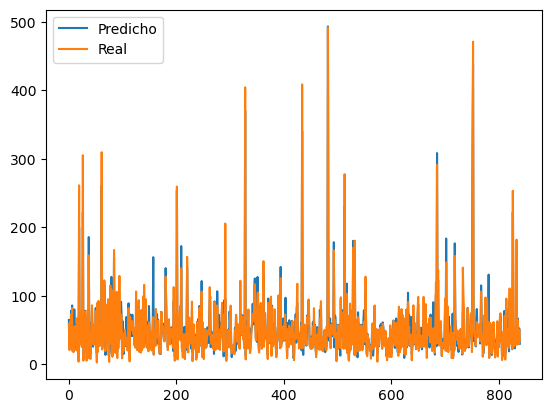

In [41]:
#Best parameters for DecisionTreeRegressor: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_split': 20, 'splitter': 'random'}
m = AdaBoostRegressor(
    estimator = DecisionTreeRegressor(criterion="friedman_mse", max_depth=None, min_samples_split=20, splitter="random"),
    n_estimators = 25,
)
yp, y_test, y_train = modelo(X,y,m,123)

In [42]:
kfold(X,y,10,m,123)

Iteration 1 completed...
Iteration 2 completed...
Iteration 3 completed...
Iteration 4 completed...
Iteration 5 completed...
Iteration 6 completed...
Iteration 7 completed...
Iteration 8 completed...
Iteration 9 completed...
Iteration 10 completed...
[14.631, 14.538, 16.189, 17.916, 17.315, 15.988, 15.908, 17.126, 18.332, 15.852]
[19.142, 20.335, 20.297, 20.814, 20.628, 20.033, 20.257, 21.031, 21.627, 21.169]
[0.896, 0.88, 0.886, 0.887, 0.859, 0.899, 0.879, 0.878, 0.88, 0.898]
[0.876, 0.858, 0.879, 0.869, 0.838, 0.885, 0.857, 0.844, 0.858, 0.874]
RMSE: 16.3795
MAPE: 20.533300000000004 %
Score: 0.8842000000000001
R2-Score: 0.8638


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

RMSE: 20.701
MAPE: 27.301 %
Score: 0.793
R2-Score: 0.759


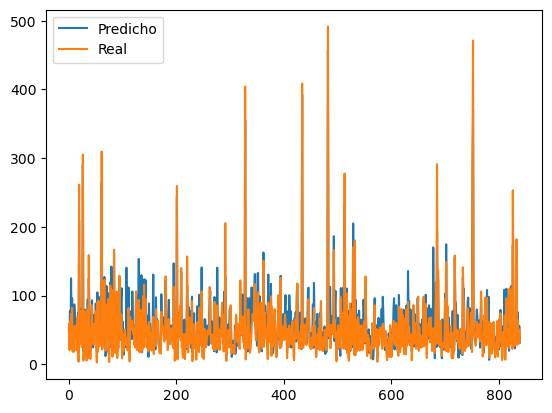

In [46]:
#Best parameters for MLPRegressor: {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
m = AdaBoostRegressor(
    estimator = MLPRegressor(activation='logistic', alpha=0.001, hidden_layer_sizes=(100,), solver='adam'),
    n_estimators = 25,
)
yp, y_test, y_train = modelo(X,y,m,123)

In [47]:
kfold(X,y,10,m,123)

C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 1 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 2 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 3 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 4 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 5 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 6 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 7 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 8 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 9 completed...


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\javil\anaco

Iteration 10 completed...
[20.747, 21.1, 21.738, 22.887, 21.69, 22.432, 21.338, 22.969, 22.761, 21.08]
[26.991, 28.898, 28.347, 28.421, 28.605, 29.168, 29.598, 28.97, 28.114, 27.741]
[0.792, 0.748, 0.794, 0.816, 0.778, 0.801, 0.783, 0.781, 0.815, 0.82]
[0.751, 0.72, 0.792, 0.773, 0.766, 0.773, 0.751, 0.734, 0.792, 0.783]
RMSE: 21.874200000000002
MAPE: 28.485299999999995 %
Score: 0.7928000000000001
R2-Score: 0.7635000000000001


C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 23.331
MAPE: 51.998 %
Score: 0.737
R2-Score: 0.759


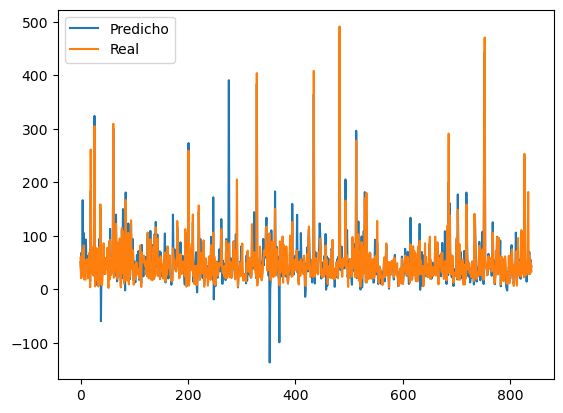

In [48]:
#Best parameters for SVR: {'C': 100.0, 'gamma': 'auto', 'kernel': 'poly'}
m = AdaBoostRegressor(
    estimator = SVR(C=100, gamma="auto", kernel="poly"),
    n_estimators = 25,
)
yp, y_test, y_train = modelo(X,y,m,123)

In [49]:
kfold(X,y,10,m,123)

Iteration 1 completed...
Iteration 2 completed...
Iteration 3 completed...
Iteration 4 completed...
Iteration 5 completed...
Iteration 6 completed...
Iteration 7 completed...
Iteration 8 completed...
Iteration 9 completed...
Iteration 10 completed...
[23.755, 19.675, 20.135, 21.086, 21.88, 20.611, 30.317, 26.194, 22.282, 24.488]
[40.61, 75.446, 38.885, 41.338, 39.488, 40.655, 32.778, 40.636, 67.069, 38.662]
[0.727, 0.781, 0.823, 0.844, 0.774, 0.832, 0.562, 0.716, 0.823, 0.758]
[0.75, 0.753, 0.829, 0.815, 0.761, 0.821, 0.67, 0.688, 0.82, 0.712]
RMSE: 23.042300000000004
MAPE: 45.5567 %
Score: 0.764
R2-Score: 0.7619


In [51]:
def custom_loss(y_true, y_pred):
    diff = y_pred - y_true
    return np.where(diff < 0, diff**2, diff).mean()

custom_scorer = make_scorer(custom_loss, greater_is_better=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Definir los modelos y sus hiperparámetros para la búsqueda
models = {
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [0.1, 1.0, 10.0, 100.0],
            'gamma': ['scale', 'auto']
        }},
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'params': {
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random'],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20]
        }
    }
}

# Realizar GridSearchCV para cada modelo y almacenar los mejores resultados
best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score (neg_mean_squared_error) for {model_name}: {grid_search.best_score_}\n")

# Evaluar los mejores modelos en el conjunto de prueba y calcular las métricas
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Evaluation metrics for {model_name}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAPE: {mape}")
    print(f"  R2-score: {r2}")
    print()

Best parameters for SVR: {'C': 100.0, 'gamma': 'auto', 'kernel': 'poly'}
Best score (neg_mean_squared_error) for SVR: -444.08336806165596



C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\javil\anaconda3\envs\PROYIII\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constrain

Best parameters for DecisionTreeRegressor: {'criterion': 'friedman_mse', 'max_depth': 30, 'min_samples_split': 20, 'splitter': 'random'}
Best score (neg_mean_squared_error) for DecisionTreeRegressor: -509.97543941543125

Evaluation metrics for SVR:
  RMSE: 20.856741434973095
  MAPE: 0.31572086112204034
  R2-score: 0.813470598883567

Evaluation metrics for DecisionTreeRegressor:
  RMSE: 23.65401193180686
  MAPE: 0.32281527155346096
  R2-score: 0.7600813524071042



In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=35)

# Definir los modelos y sus hiperparámetros para GridSearchCV
models_and_parameters = {

    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'parameters': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 7, 10],
            'min_samples_leaf': [1, 2, 3, 4]
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'parameters': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBRegressor': {
        'model': xgb.XGBRegressor(objective='reg:squarederror'),
        'parameters': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6],
            'min_child_weight': [1, 3, 5],
            'subsample': [0.4, 0.6],
            'colsample_bytree': [0.4, 0.6, 0.8]
        }
    },
    'LGBMRegressor': {
        'model': lgb.LGBMRegressor(),
        'parameters': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5],
            'num_leaves': [31, 50],
            'min_child_samples': [20, 50],
            'subsample': [0.6, 0.8],
            'colsample_bytree': [0.4, 0.6]
        }
    }
}

# Realizar GridSearchCV para cada modelo
best_estimators = {}
for model_name, mp in models_and_parameters.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(mp['model'], mp['parameters'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

# Evaluar los mejores modelos en el conjunto de prueba
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = root_mean_squared_error(y_test, y_pred)
    print("-"*20)
    print(f"{model_name} test RMSE: {mse}")

print()
print("#"*20)
print()

# Output final de los mejores modelos y sus parámetros
for model_name, model in best_estimators.items():
    print("-"*20)
    print(f"Best model for {model_name}: {model}")

Training RandomForestRegressor...
Best parameters for RandomForestRegressor: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score for RandomForestRegressor: -350.96981998181656
Training GradientBoostingRegressor...
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score for GradientBoostingRegressor: -294.8746619864879
Training XGBRegressor...
Best parameters for XGBRegressor: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.6}
Best score for XGBRegressor: -266.55838528618847
Training LGBMRegressor...
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

In [53]:
m = AdaBoostRegressor(
    estimator = DecisionTreeRegressor(criterion='friedman_mse', max_depth=20, min_samples_split=10, splitter='random'),
    n_estimators = 25,
)

In [54]:
kfold(X,y,10,m)

Iteration 1 completed...
Iteration 2 completed...
Iteration 3 completed...
Iteration 4 completed...
Iteration 5 completed...
Iteration 6 completed...
Iteration 7 completed...
Iteration 8 completed...
Iteration 9 completed...
Iteration 10 completed...
[19.159, 14.373, 16.902, 15.784, 16.216, 18.004, 15.606, 17.549, 16.744, 16.881]
[22.741, 20.659, 20.483, 20.559, 21.15, 22.775, 21.085, 21.134, 21.713, 19.507]
[0.85, 0.894, 0.881, 0.868, 0.914, 0.84, 0.92, 0.867, 0.871, 0.864]
[0.83, 0.871, 0.862, 0.843, 0.897, 0.782, 0.908, 0.823, 0.84, 0.862]
RMSE: 16.721799999999998
MAPE: 21.180600000000002 %
Score: 0.8769000000000002
R2-Score: 0.8518000000000001


In [57]:
m1 = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree= 0.8, learning_rate= 0.1,
                     max_depth= 5, min_child_weight= 5, n_estimators= 200, subsample= 0.6)
m2 = SVR(C=100, kernel='poly')
m3 = GradientBoostingRegressor(max_depth=4, n_estimators=200)
m = StackingRegressor(estimators=[("xgb", m1),
                                  ("svm", m2),
                                  ("gbr", m3)],
                  final_estimator = RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=300))

In [58]:
kfold(X,y,10,m)

Iteration 1 completed...
Iteration 2 completed...
Iteration 3 completed...
Iteration 4 completed...
Iteration 5 completed...
Iteration 6 completed...
Iteration 7 completed...
Iteration 8 completed...
Iteration 9 completed...
Iteration 10 completed...
[19.164, 15.385, 15.722, 16.939, 15.581, 15.945, 15.688, 16.712, 15.627, 17.589]
[22.368, 21.362, 21.132, 20.346, 22.814, 22.832, 21.277, 20.991, 21.578, 19.584]
[0.85, 0.879, 0.897, 0.847, 0.92, 0.874, 0.92, 0.88, 0.887, 0.853]
[0.852, 0.863, 0.89, 0.832, 0.903, 0.861, 0.914, 0.859, 0.868, 0.862]
RMSE: 16.435200000000002
MAPE: 21.428400000000003 %
Score: 0.8807
R2-Score: 0.8704000000000001
